In [1]:
import os
import json
import torch
import pandas as pd
from torch import nn
from tqdm import tqdm
from PIL import Image
from torch.optim import Adam
from torchinfo import summary
import matplotlib.pyplot as plt
from torchvision import datasets
from torchvision import transforms
from torch.nn import CrossEntropyLoss
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, random_split, Dataset, ConcatDataset, RandomSampler

In [2]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(232, transforms.InterpolationMode.BILINEAR, antialias=True),
        transforms.CenterCrop(224),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])


def generate_dataloaders(path: str, batch_size: int) -> tuple[DataLoader, DataLoader, list[str]]:
    """Generates training and testing dataloaders from a dataset in given path
    The dataset must be arranged as such:
    .../class1/x1.png
    .../class1/x2.png
    .../class1/x3.png
    .../class2/x1.png
    .../class2/x2.png
    .../class2/x3.png

    :param path: Path to the datasets folder
    :param batch_size: Batch size of data loader
    :return: Train and test dataloader and class names
    """
    animal_data = datasets.ImageFolder(os.path.join(path, "animal-image-dataset-90-different-animals", "animals", "animals"), transform)
    
    # Sampling randomly to get same amount of bg as other classes
    num_samples = round(len(animal_data)/len(animal_data.classes))
    df_ids = pd.read_csv(os.path.join(path, "stanford-background-dataset", "metadata.csv"))["image_id"].sample(num_samples)
    bg_data = NotAnimalDataset(os.path.join(path, "stanford-background-dataset", "images"), df_ids, transform)
    
    data = ConcatDataset([animal_data, bg_data])
    test_data, train_data = random_split(data, [0.2, 0.8])
    
    workers = max(os.cpu_count() - 1, 1)
    test_loader = DataLoader(test_data, batch_size, shuffle=False, num_workers=workers)
    train_loader = DataLoader(train_data, batch_size, shuffle=True, num_workers=workers)
    
    return train_loader, test_loader, animal_data.classes + ["nenhum"]


class NotAnimalDataset(Dataset):
    """Dataset with images without animals in them
    """
    CLASS_LABEL = 90
    
    def __init__(self, path: str, file_names: pd.DataFrame, transform: transforms.Compose = None) -> None:
        super().__init__()
        self.file_names = file_names
        self.path = path
        self.transform = transform
    
    def __len__(self):
        return len(self.file_names)

    def __getitem__(self, index):
        image_name = f"{self.file_names.iloc[index]:0>7}"
        image_path = os.path.join(self.path, f"{image_name}.jpg")
        
        image = Image.open(image_path)
        if self.transform:
            image = self.transform(image)
        
        return image, self.CLASS_LABEL

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
lr = 1e-4
epochs = 10
batch_size = 16

In [4]:
train_dl, test_dl, classes = generate_dataloaders("/kaggle/input/", batch_size)

In [5]:
def load_model():
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
    return model
model = load_model()

In [6]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
for param in model.parameters():
    param.requires_grad = False

In [8]:
model.fc = nn.Sequential(
    nn.Dropout(p=0.2, inplace=True),
    nn.Linear(in_features=model.fc.in_features, out_features=1024),
    nn.ReLU(),
    nn.Linear(in_features=1024, out_features=91),
)

In [9]:
summary(model, (16, 3, 224, 224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
ResNet                                   [16, 3, 224, 224]         [16, 91]                  --                        Partial
├─Conv2d: 1-1                            [16, 3, 224, 224]         [16, 64, 112, 112]        (9,408)                   False
├─BatchNorm2d: 1-2                       [16, 64, 112, 112]        [16, 64, 112, 112]        (128)                     False
├─ReLU: 1-3                              [16, 64, 112, 112]        [16, 64, 112, 112]        --                        --
├─MaxPool2d: 1-4                         [16, 64, 112, 112]        [16, 64, 56, 56]          --                        --
├─Sequential: 1-5                        [16, 64, 56, 56]          [16, 256, 56, 56]         --                        False
│    └─Bottleneck: 2-1                   [16, 64, 56, 56]          [16, 256, 56, 56]         --                        False


In [10]:
metrics = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
}

In [11]:
def train_step(model, dataloader, criterion, optimizer, device):
    model.train()
    train_loss, train_acc = 0, 0
    
    for X, y in tqdm(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward Propagation
        y_pred = model(X)
        
        # Loss calc
        loss = criterion(y_pred, y)
        train_loss += loss.item()
        
        # Reset gradients
        optimizer.zero_grad()
        
        # Backwards propagation
        loss.backward()
        
        # Update values
        optimizer.step()
        
        # Calculate accuracy
        pred_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (pred_label == y).sum().item()/len(y_pred)
    
    train_loss, train_acc = train_loss/len(dataloader), train_acc/len(dataloader)
    
    return train_loss, train_acc


def test_step(model, dataloader, criterion, optimizer, device):
    model.eval()
    test_loss, test_acc = 0, 0
    
    with torch.no_grad():
        for X, y in tqdm(dataloader):
            X, y = X.to(device), y.to(device)
            
            # Forward Propagation
            y_pred = model(X)
            
            # Loss calc
            loss = criterion(y_pred, y)
            test_loss += loss.item()
            
            # Calculate accuracy
            pred_label = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
            test_acc += (pred_label == y).sum().item()/len(y_pred)
            
    test_loss, test_acc = test_loss/len(dataloader), test_acc/len(dataloader)
    
    return test_loss, test_acc


def train(model, train_dataloader, test_dataloader, epochs, criterion, optimizer, device):
    metrics = {
    "train_loss": [],
    "train_acc": [],
    "test_loss": [],
    "test_acc": [],
    }
    for epoch in range(1, epochs+1):
        print("EPOCH", epoch)
        train_loss, train_acc = train_step(model, train_dataloader, criterion, optimizer, device)
        test_loss, test_acc = test_step(model,test_dataloader, criterion, optimizer, device)
        metrics["train_loss"].append(train_loss)
        metrics["train_acc"].append(train_acc)
        metrics["test_loss"].append(test_loss)
        metrics["test_acc"].append(test_acc)
        print(f"Epoch {epoch} - {train_loss=:.4f}, {train_acc=:.4f}, {test_loss=:.4f}, {test_acc=:.4f}")
    return metrics


In [12]:
loss_fn = CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=lr/10)
device

'cuda'

In [13]:
results = train(model, train_dl, test_dl, epochs, loss_fn, optimizer, device)

EPOCH 1


100%|██████████| 69/69 [00:13<00:00,  5.04it/s]


Epoch 1 - train_loss=3.6440, train_acc=0.4309, test_loss=2.5453, test_acc=0.8216
EPOCH 2


100%|██████████| 69/69 [00:14<00:00,  4.91it/s]


Epoch 2 - train_loss=1.6404, train_acc=0.8006, test_loss=1.2412, test_acc=0.8687
EPOCH 3


100%|██████████| 69/69 [00:13<00:00,  5.02it/s]


Epoch 3 - train_loss=0.8789, train_acc=0.8729, test_loss=0.7969, test_acc=0.8850
EPOCH 4


100%|██████████| 69/69 [00:13<00:00,  5.24it/s]


Epoch 4 - train_loss=0.6147, train_acc=0.8885, test_loss=0.5903, test_acc=0.9067
EPOCH 5


100%|██████████| 69/69 [00:13<00:00,  5.08it/s]


Epoch 5 - train_loss=0.4788, train_acc=0.9103, test_loss=0.5059, test_acc=0.9058
EPOCH 6


100%|██████████| 69/69 [00:13<00:00,  4.94it/s]


Epoch 6 - train_loss=0.3935, train_acc=0.9249, test_loss=0.4731, test_acc=0.8995
EPOCH 7


100%|██████████| 69/69 [00:13<00:00,  5.23it/s]


Epoch 7 - train_loss=0.3325, train_acc=0.9343, test_loss=0.3981, test_acc=0.9149
EPOCH 8


100%|██████████| 69/69 [00:13<00:00,  5.02it/s]


Epoch 8 - train_loss=0.2823, train_acc=0.9414, test_loss=0.3824, test_acc=0.9176
EPOCH 9


100%|██████████| 69/69 [00:14<00:00,  4.85it/s]


Epoch 9 - train_loss=0.2519, train_acc=0.9501, test_loss=0.3687, test_acc=0.9185
EPOCH 10


100%|██████████| 69/69 [00:14<00:00,  4.78it/s]

Epoch 10 - train_loss=0.2257, train_acc=0.9579, test_loss=0.3588, test_acc=0.9130


In [15]:
def save_model(model, path='model.pth'):
    torch.save(model.state_dict(), path)
    
def save_results(results, path='results.json'):
    with open(path, "w") as f:
        json.dump(results, f)

save_model(model)

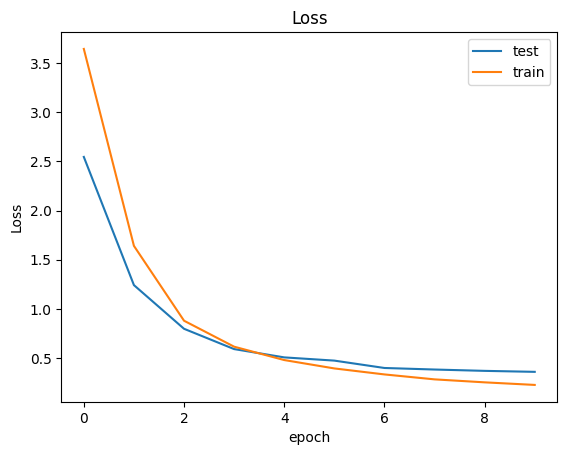

In [16]:
def plot_series(test, train, title):
  plt.plot(test, label='test')
  plt.plot(train, label='train')
  plt.title(title);
  plt.ylabel(title.split()[0]);
  plt.xlabel('epoch')
  plt.legend()
  plt.show()

plot_series(results["test_loss"], results["train_loss"], "Loss")

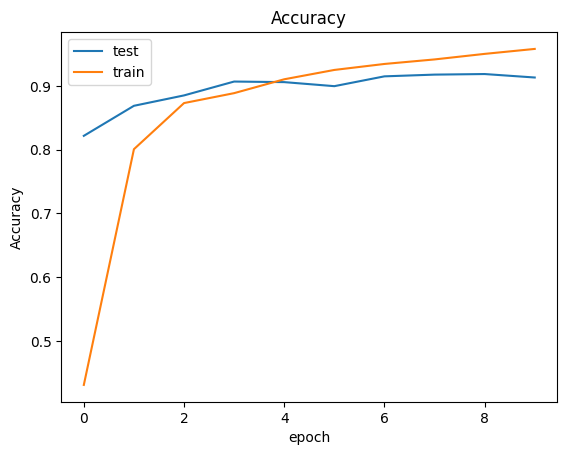

In [17]:
plot_series(results["test_acc"], results["train_acc"], "Accuracy")